In [21]:
import pandas as pd

df = pd.read_csv(r"C:\Users\jawri\Data course\Capstone\CORDIS data\Projects\project_features_clean.csv")
print(df.head())



   projectID  partnertype_HES  partnertype_OTH  partnertype_PRC  \
0     115842                7                0                2   
1     115843                6                2                4   
2     115844                1                1                1   
3     115847                1                4                1   
4     115848                0                1                2   

   partnertype_PUB  partnertype_REC  has_sme  country_AE  country_AI  \
0                1                3     True           0           0   
1                0                6     True           0           0   
2                0                1     True           0           0   
3                0                0    False           0           0   
4                0                3     True           0           0   

   country_AL  ...  topiclvl3_zoology  duration_months   totalCost  \
0           0  ...                  0             48.0   4786010.0   
1           0  ...      

In [23]:
# begin citations model
exclude_cols = ['projectID', 'num_citations', 'num_publications', 'num_patents', 'total_output']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df['num_citations']


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)

print("Cross-validated RMSE scores:", rmse_scores)
print("Average cross-validated RMSE:", rmse_scores.mean())


Cross-validated RMSE scores: [1278.01362698 2027.28801559 2138.66853932 1396.50915632 1271.56946138]
Average cross-validated RMSE: 1622.4097599189088


In [29]:
print("Mean citations:", y.mean())
print("Std citations:", y.std())
print("Median citations:", y.median())


Mean citations: 384.4801013024602
Std citations: 1865.744131355415
Median citations: 0.0


C:\Users\jawri\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test RMSE: 1997.104476991108
Test R²: 0.06908118766528559


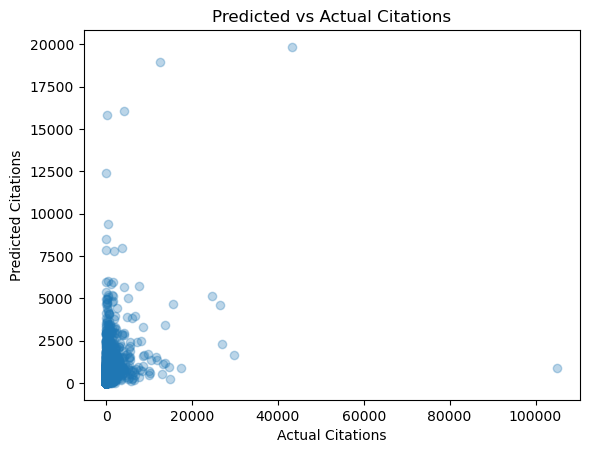

In [31]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R²:", r2_score(y_test, y_pred))

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Citations')
plt.ylabel('Predicted Citations')
plt.title('Predicted vs Actual Citations')
plt.show()


In [33]:
from sklearn.model_selection import GridSearchCV

# hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],        
    'max_depth': [None, 10, 20],       
    'min_samples_split': [2, 5, 10]    
}

# Set up the Random Forest and GridSearchCV
rf_grid = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_grid, param_grid, cv=5,
    scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Output best settings and performance
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated RMSE:", np.sqrt(-grid_search.best_score_))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated RMSE: 1646.6725522767342


In [35]:
#citations
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_pred_best, squared=False))
print("Test R²:", r2_score(y_test, y_pred_best))


Test RMSE: 1992.6303152917003
Test R²: 0.07324763541692747


C:\Users\jawri\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/150.0 MB 8.4 MB/s eta 0:00:18
    --------------------------------------- 3.1/150.0 MB 8.4 MB/s eta 0:00:18
   - -------------------------------------- 5.0/150.0 MB 8.4 MB/s eta 0:00:18
   - -------------------------------------- 6.8/150.0 MB 8.4 MB/s eta 0:00:18
   -- ------------------------------------- 8.7/150.0 MB 8.4 MB/s eta 0:00:17
   -- ------------------------------------- 10.2/150.0 MB 8.5 MB/s eta 0:00:17
   --- ------------------------------------ 12.1/150.0 MB 8.4 MB/s eta 0:00:17
   --- ------------------------------------ 13.9/150.0 MB 8.5 MB/s eta 0:00:17
   ---- ----------------------------------- 15.7/150.0 MB 8.4 MB/s eta 0:00:17
   ---- ----------------------------------- 17.3/150.0 MB 8.5 MB/s eta 0:00:16
   ----- ---------------------------------- 19.1/150.0 MB 8.4 MB/s eta 0:00:16
   ----- ---------------------------------- 20.7/150.0 MB 8.4 MB/

In [41]:
import xgboost as xgb

# Create and train the model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Test RMSE:", mean_squared_error(y_test, y_pred_xgb, squared=False))
print("XGBoost Test R²:", r2_score(y_test, y_pred_xgb))


XGBoost Test RMSE: 2090.3037899594756
XGBoost Test R²: -0.019832968711853027


C:\Users\jawri\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:

# Load original features
features = pd.read_csv(r"C:\Users\jawri\Data course\Capstone\CORDIS data\Projects\project_features_clean.csv")

# Define feature columns used in modeling
exclude_cols = ['projectID', 'num_citations', 'num_publications', 'num_patents', 'total_output']
feature_cols = [col for col in features.columns if col not in exclude_cols]

X = features[feature_cols]
y = features['num_citations']

# Train best model on full data
best_rf.fit(X, y)

# Make a copy to add predictions
features_with_preds = features.copy()
features_with_preds['pred_citations'] = best_rf.predict(X)

# Save to a new CSV to keep original safe
features_with_preds.to_csv(r"C:\Users\jawri\Data course\Capstone\CORDIS data\Projects\project_features_with_predictions.csv", index=False)


In [47]:
!pip install shap


   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 9.1 MB/s eta 0:00:00


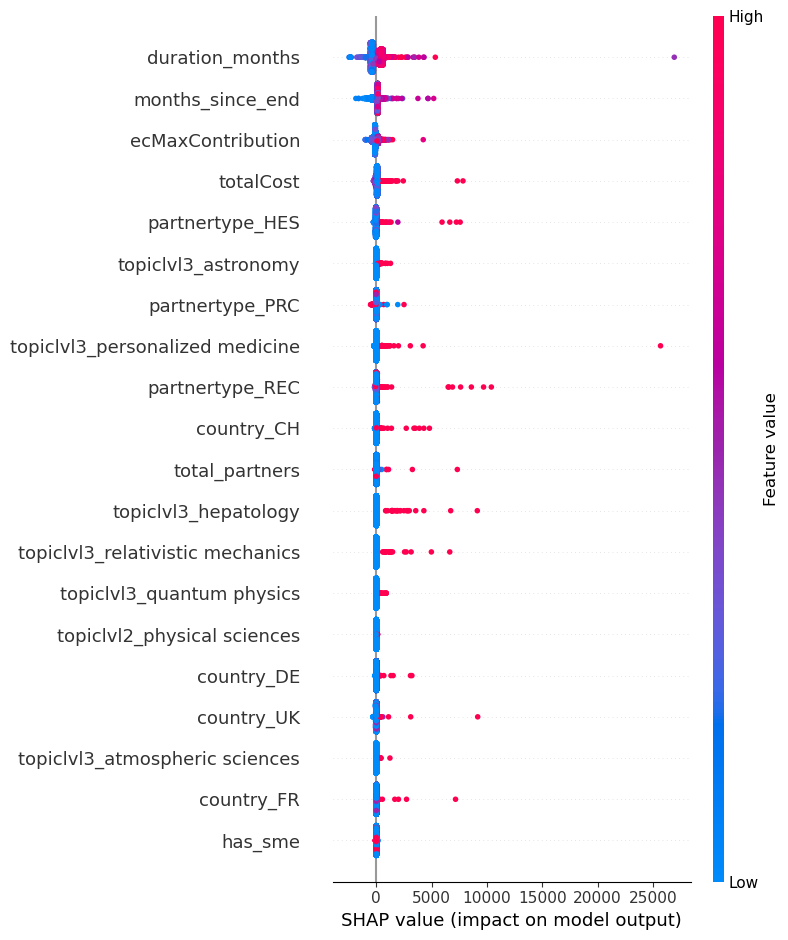

In [49]:
import shap

# Create SHAP explainer for model
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Summary plot of feature
shap.summary_plot(shap_values, X)


In [51]:
xplainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = dict(zip(X.columns, mean_abs_shap))
# Sort and print top features with exact values
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print(sorted_importance[:10])

[('duration_months', 370.5652380508496), ('months_since_end', 177.7176006591434), ('ecMaxContribution', 146.36128298559242), ('totalCost', 71.998518873085), ('partnertype_HES', 23.19244295728712), ('topiclvl3_astronomy', 15.740535219300474), ('partnertype_PRC', 14.782052457568955), ('topiclvl3_personalized medicine', 12.947980641496176), ('partnertype_REC', 10.251205452242857), ('country_CH', 10.000975518906618)]


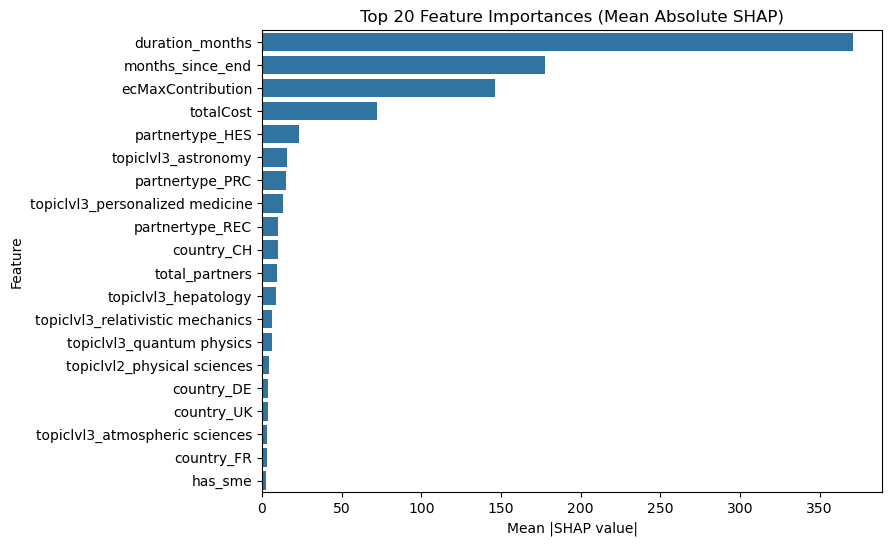

In [55]:
import seaborn as sns

mean_abs_shap = np.abs(shap_values).mean(axis=0)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': mean_abs_shap
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances (Mean Absolute SHAP)')
plt.xlabel('Mean |SHAP value|')
plt.ylabel('Feature')
plt.show()


In [57]:
# Define features and target for publications
exclude_cols = ['projectID', 'num_citations', 'num_publications', 'num_patents', 'total_output']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X_pub = df[feature_cols]
y_pub = df['num_publications']

In [61]:
# Train/test split
from sklearn.model_selection import train_test_split
X_train_pub, X_test_pub, y_train_pub, y_test_pub = train_test_split(
    X_pub, y_pub, test_size=0.3, random_state=42
)

# Hyperparameter grid 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_grid = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_pub = GridSearchCV(
    rf_grid, param_grid, cv=5,
    scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)

# Fit grid search on publication training data
grid_search_pub.fit(X_train_pub, y_train_pub)

# Best model and performance
best_rf_pub = grid_search_pub.best_estimator_
y_pred_pub = best_rf_pub.predict(X_test_pub)

print("Best parameters for publications:", grid_search_pub.best_params_)
print("Publications Test RMSE:", mean_squared_error(y_test_pub, y_pred_pub, squared=False))
print("Publications Test R²:", r2_score(y_test_pub, y_pred_pub))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for publications: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Publications Test RMSE: 22.524601153527815
Publications Test R²: 0.37862873679990217


C:\Users\jawri\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [63]:

# Define feature columns for modeling (exclude targets and ID only)
exclude_cols = ['projectID', 'num_citations', 'num_publications', 'num_patents', 'total_output']
feature_cols = [col for col in features.columns if col not in exclude_cols]

X_pub = features[feature_cols]

# Train the best publications model on full clean data
y_pub = features['num_publications']
best_rf_pub.fit(X_pub, y_pub)

# Load existing predictions CSV (contains pred_citations)
pred_file = r"C:\Users\jawri\Data course\Capstone\CORDIS data\Projects\project_features_with_predictions.csv"
features_with_preds = pd.read_csv(pred_file)

# Add publication predictions to existing predictions DataFrame
features_with_preds['pred_publications'] = best_rf_pub.predict(X_pub)

# Save updated predictions CSV (preserves pred_citations)
features_with_preds.to_csv(pred_file, index=False)


In [ ]:
# Load data
features = pd.read_csv(r"C:\Users\jawri\Data course\Capstone\CORDIS data\Projects\project_features_clean.csv")

# Define features and target
exclude_cols = ['projectID', 'num_citations', 'num_publications', 'num_patents', 'total_output']
feature_cols = [col for col in features.columns if col not in exclude_cols]

X_pub = features[feature_cols]
y_pub = features['num_publications']

# Train model with best params
best_rf_pub = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
best_rf_pub.fit(X_pub, y_pub)

# Sample for SHAP
X_sample = X_pub.sample(100, random_state=42)

# SHAP explainer and values
explainer_pub = shap.TreeExplainer(best_rf_pub)
shap_values_pub = explainer_pub.shap_values(X_sample)

# Summary plot
shap.summary_plot(shap_values_pub, X_sample)

# Mean absolute SHAP values and bar plot
mean_abs_shap_pub = np.abs(shap_values_pub).mean(axis=0)
feature_importance_pub = pd.DataFrame({'feature': X_sample.columns, 'importance': mean_abs_shap_pub}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feature_importance_pub.head(20))
plt.title('Top 20 Feature Importances (Mean Absolute SHAP) - Publications (Sampled)')
plt.xlabel('Mean |SHAP value|')
plt.ylabel('Feature')
plt.show()


In [5]:
import pandas as pd
features = pd.read_csv(r"C:\Users\jawri\Data course\Capstone\CORDIS data\Projects\project_features_clean.csv")

In [7]:
mean_publications = features['num_publications'].mean()
std_publications = features['num_publications'].std()
median_publications = features['num_publications'].median()

print(f"Mean publications: {mean_publications}")
print(f"Std publications: {std_publications}")
print(f"Median publications: {median_publications}")


Mean publications: 11.31210805595755
Std publications: 26.130315238471656
Median publications: 3.0
